In [1]:
from timeit import default_timer as time
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

# Data Explore

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Shawn-zou-2020/MyProjects/main/Fraud%20Analysis/Card%20Application%20Fraud%20Analysis/Raw%20Data/applications%20data.csv')

In [3]:
data.shape

(1000000, 10)

In [4]:
len(data['record'])

1000000

In [5]:
data.head(10)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0
5,6,20160101,922264214,XEEJJSTER,ERJSAXA,4322 USJXU LN,8391,19480613,5742016319,0
6,7,20160101,415812149,XZJRJUSRR,STSMJRUM,478 EEXUM LN,41640,19640318,7697396312,0
7,8,20160101,373752050,EJMRRSUXR,AMTZXRU,8906 UUAJ PL,60567,19190528,2727421586,0
8,9,20160101,769970791,RXTSZJATS,RSXMRJME,8266 SSEAR RD,37934,19900314,5520652307,0
9,10,20160101,732119085,EREMTZXXA,EXMMSEXT,9166 XXSAZ PL,93751,19750127,3749451123,0


In [6]:
data.dtypes

record          int64
date            int64
ssn             int64
firstname      object
lastname       object
address        object
zip5            int64
dob             int64
homephone       int64
fraud_label     int64
dtype: object

In [7]:
data['appyear'] = (data['date'] / 10000).astype('int')
data['appmonth'] = ((data['date'] - data['appyear'] * 10000) / 100).astype('int')
data['appday'] = data['date'] - data['appyear'] * 10000 - data['appmonth'] * 100
data['date'] = pd.to_datetime(data.appyear*10000+data.appmonth*100+data.appday,format='%Y%m%d')
data = data.drop(columns = ['appyear','appmonth','appday'])

In [8]:
data.dtypes

record                  int64
date           datetime64[ns]
ssn                     int64
firstname              object
lastname               object
address                object
zip5                    int64
dob                     int64
homephone               int64
fraud_label             int64
dtype: object

In [9]:
data.head(5)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


In [10]:
data.tail(5)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
999995,999996,2016-12-31,766104848,XUSAAURMZ,EJXXEXZX,8079 EJRUJ AVE,54890,19550418,8236558223,0
999996,999997,2016-12-31,445178058,SAAJJEMTX,UMAUETJX,4817 UMSXT AVE,74683,19150624,6790134432,0
999997,999998,2016-12-31,25283410,ESRXXRSUX,EUEJRJJE,7562 RJMAZ ST,86805,19880628,3997657622,0
999998,999999,2016-12-31,361232148,XXMZSRXMA,RSRSUJSS,3408 UZZAM WY,49183,20120302,5935293731,0
999999,1000000,2016-12-31,40027083,RXZXSMEZA,UTEAAZXU,112 UTTJT PL,39491,19820826,5869926905,0


In [11]:
data.describe()

,record,ssn,zip5,dob,homephone,fraud_label
count,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000
mean,500000.500000,5.083415e+08,50073.333143,1.951725e+07,5.368716e+09,0.014393
std,288675.278933,2.934864e+08,28915.921546,3.568872e+05,3.082161e+09,0.119104
min,1.000000,3.600000e+01,2.000000,1.900010e+07,5.937990e+05,0.000000
25%,250000.750000,2.542176e+08,24992.000000,1.916092e+07,2.677134e+09,0.000000
50%,500000.500000,5.088144e+08,50492.000000,1.950090e+07,5.399910e+09,0.000000
75%,750000.250000,7.630924e+08,74496.000000,1.983032e+07,8.109241e+09,0.000000
max,1000000.000000,1.000000e+09,99999.000000,2.016103e+07,1.000000e+10,1.000000


In [12]:
data.count()

record         1000000
date           1000000
ssn            1000000
firstname      1000000
lastname       1000000
address        1000000
zip5           1000000
dob            1000000
homephone      1000000
fraud_label    1000000
dtype: int64

In [13]:
data['fraud_label'].sum()

14393

In [14]:
print(len(data[data['fraud_label'] == 0]))

985607


In [15]:
print(len(data[data['fraud_label'] == 0]) + len(data[data['fraud_label'] != 0]))

1000000


In [16]:
goods = data[data['fraud_label'] == 0]
bads = data[data['fraud_label'] == 1]

In [17]:
numrecords = len(data)
print(numrecords)

1000000


In [18]:
print(len(goods))

985607


In [19]:
print(len(bads))

14393


In [20]:
len(data['record'].unique())

1000000

In [21]:
len(data['record']) * 100 / numrecords

100.0

In [22]:
len(data['date']) * 100 / numrecords

100.0

In [23]:
len(data['date'].unique())

365

In [24]:
data.min()

record                           1
date           2016-01-01 00:00:00
ssn                             36
firstname                 AAAEEETR
lastname                   AAAAARA
address                  0 EAJA DR
zip5                             2
dob                       19000101
homephone                   593799
fraud_label                      0
dtype: object

In [25]:
data.max()

record                     1000000
date           2016-12-31 00:00:00
ssn                      999999999
firstname                 ZZZZZRMR
lastname                   ZZZZXER
address              9999 XZSXM WY
zip5                         99999
dob                       20161031
homephone               9999999999
fraud_label                      1
dtype: object

In [26]:
count_day = data.groupby('date').count()
count_day.head(10)

,record,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
date,,,,,,,,,
2016-01-01,2840,2840,2840,2840,2840,2840,2840,2840,2840
2016-01-02,2719,2719,2719,2719,2719,2719,2719,2719,2719
2016-01-03,2764,2764,2764,2764,2764,2764,2764,2764,2764
2016-01-04,2757,2757,2757,2757,2757,2757,2757,2757,2757
2016-01-05,2732,2732,2732,2732,2732,2732,2732,2732,2732
2016-01-06,2682,2682,2682,2682,2682,2682,2682,2682,2682
2016-01-07,2782,2782,2782,2782,2782,2782,2782,2782,2782
2016-01-08,2809,2809,2809,2809,2809,2809,2809,2809,2809
2016-01-09,2779,2779,2779,2779,2779,2779,2779,2779,2779


<AxesSubplot:title={'center':'Daily Applications'}, xlabel='date'>

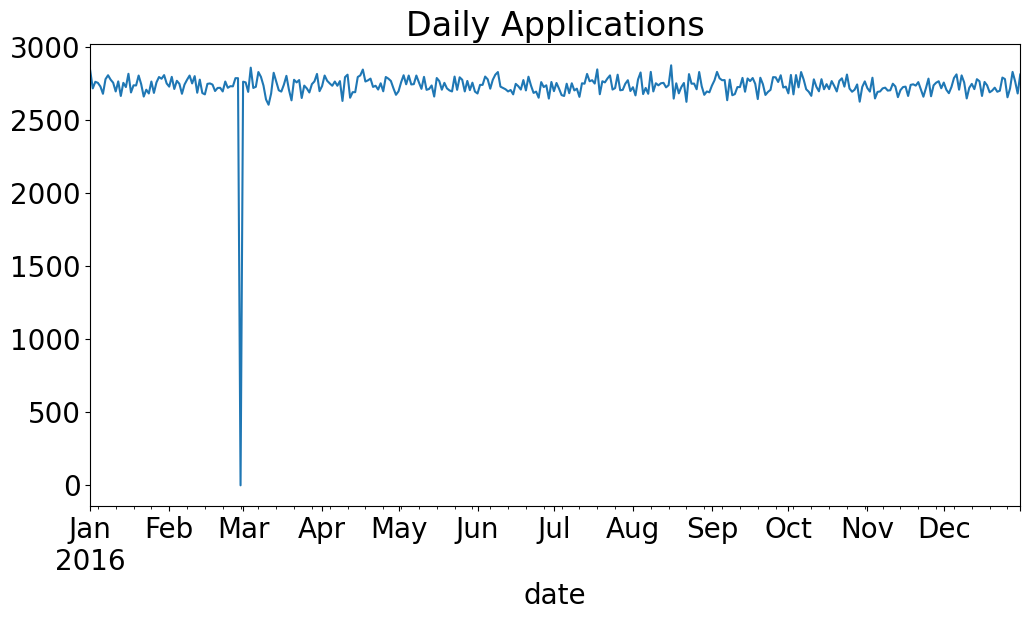

In [27]:
daily_count = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 1))\
    .count().apps
daily_count.plot(title = 'Daily Applications')

<AxesSubplot:title={'center':'Daily Applications'}, xlabel='date'>

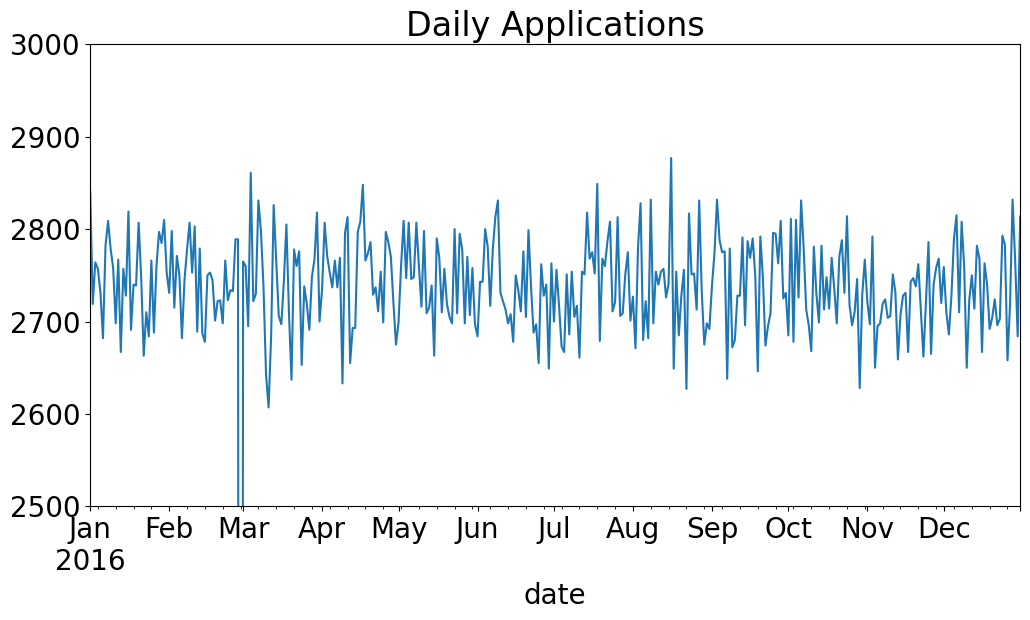

In [28]:
daily_count = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 1))\
    .count().apps
plt.ylim(2500,3000)
daily_count.plot(title = 'Daily Applications')

In [29]:
daily_count.head(70)

date
2016-01-01    2840
2016-01-02    2719
2016-01-03    2764
2016-01-04    2757
2016-01-05    2732
              ... 
2016-03-06    2730
2016-03-07    2831
2016-03-08    2798
2016-03-09    2738
2016-03-10    2643
Freq: D, Name: apps, Length: 70, dtype: int64

In [30]:
daily_count['2016-02-29'] = daily_count['2016-02-28']
daily_count.head(70)

date
2016-01-01    2840
2016-01-02    2719
2016-01-03    2764
2016-01-04    2757
2016-01-05    2732
              ... 
2016-03-06    2730
2016-03-07    2831
2016-03-08    2798
2016-03-09    2738
2016-03-10    2643
Freq: D, Name: apps, Length: 70, dtype: int64

<AxesSubplot:title={'center':'Daily Applications'}, xlabel='date'>

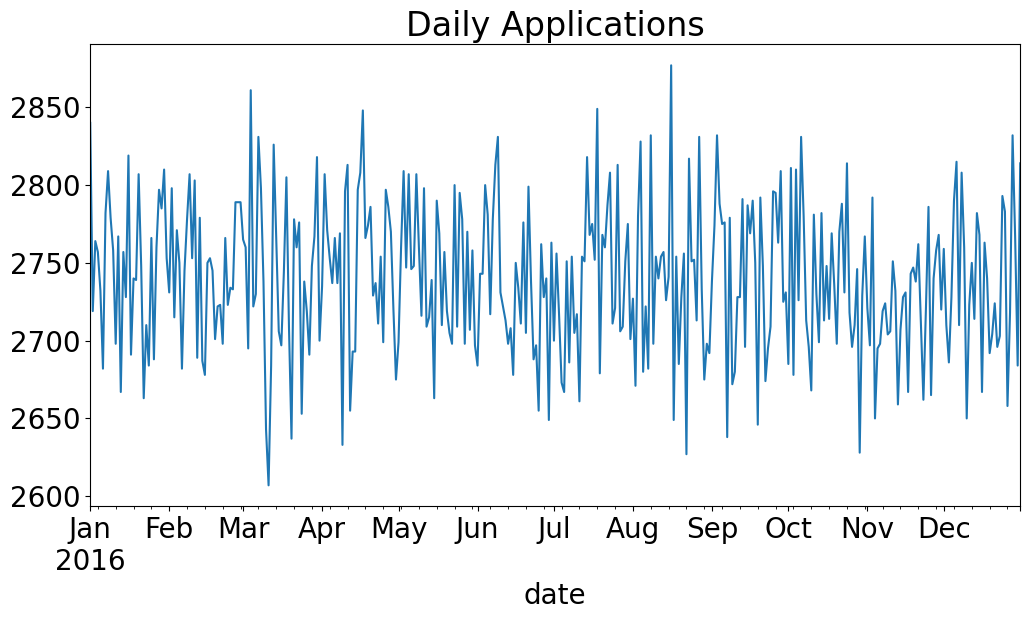

In [31]:
daily_count.plot(title = 'Daily Applications')

<AxesSubplot:title={'center':'Daily Applicationss'}, xlabel='date'>

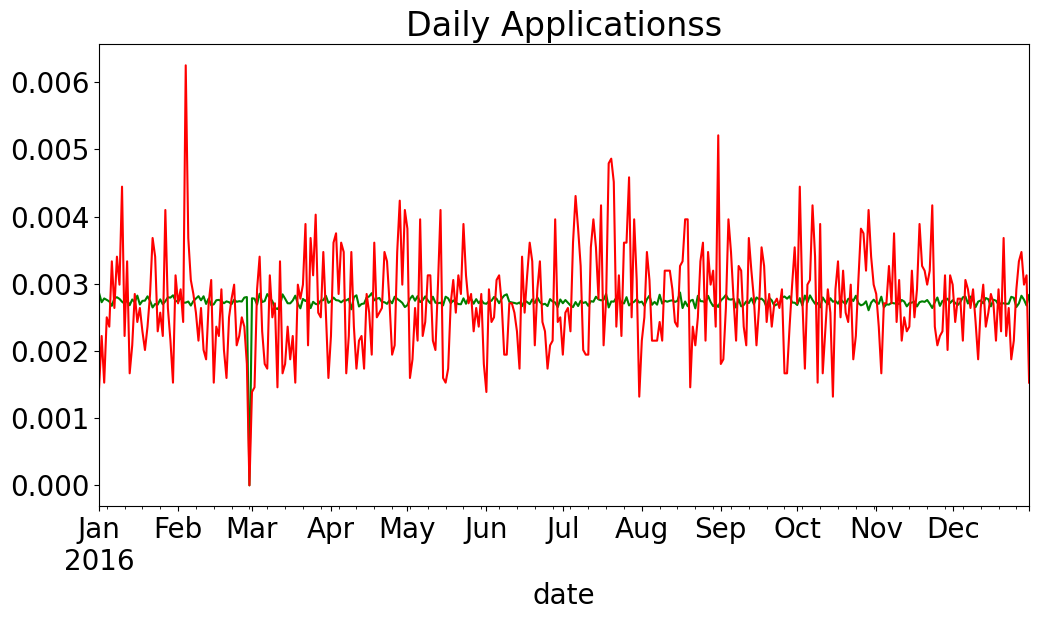

In [32]:
ngoods = len(goods)
nbads = len(bads)
goods_series = goods.assign(apps = np.ones(ngoods)).set_index(goods['date']).resample(dt.timedelta(days = 1)).count().apps
norm_goods_series = goods_series / ngoods
norm_goods_series.plot(title = 'Daily Applicationss', color = 'green')
bads_series = bads.assign(apps = np.ones(nbads)).set_index(bads['date']).resample(dt.timedelta(days = 1)).count().apps
norm_bads_series = bads_series / nbads
norm_bads_series.plot(color = 'red')

Text(0, 0.5, 'Proportion')

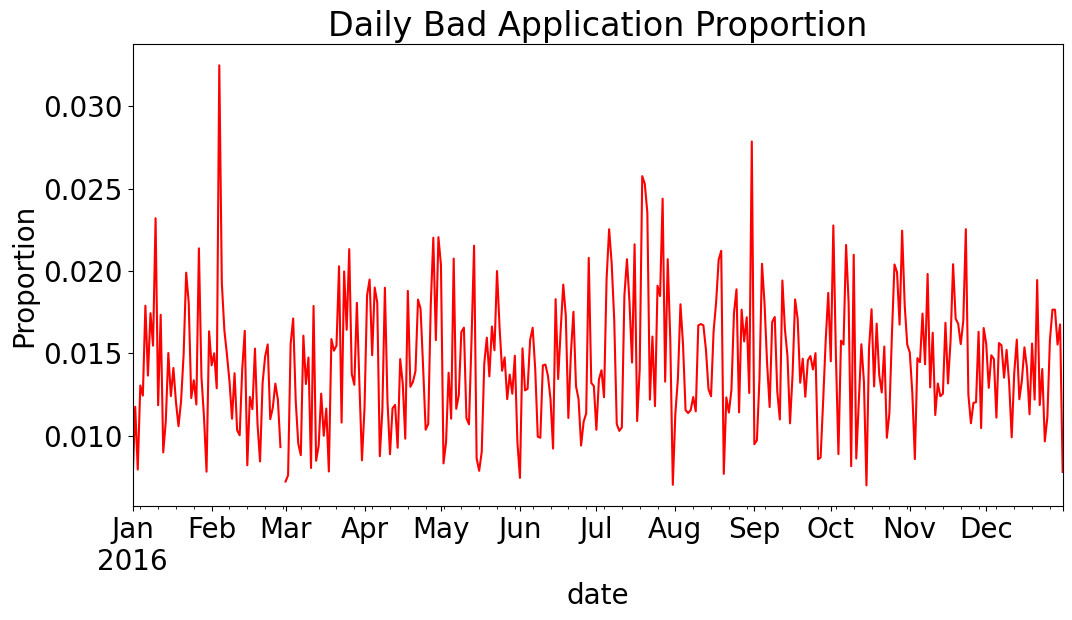

In [33]:
tt_series=goods_series+bads_series
pp_bads_series = bads_series / tt_series
pp_bads_series.plot(color = 'red')
plt.title('Daily Bad Application Proportion')
plt.ylabel('Proportion')

Text(0, 0.5, 'Proportion')

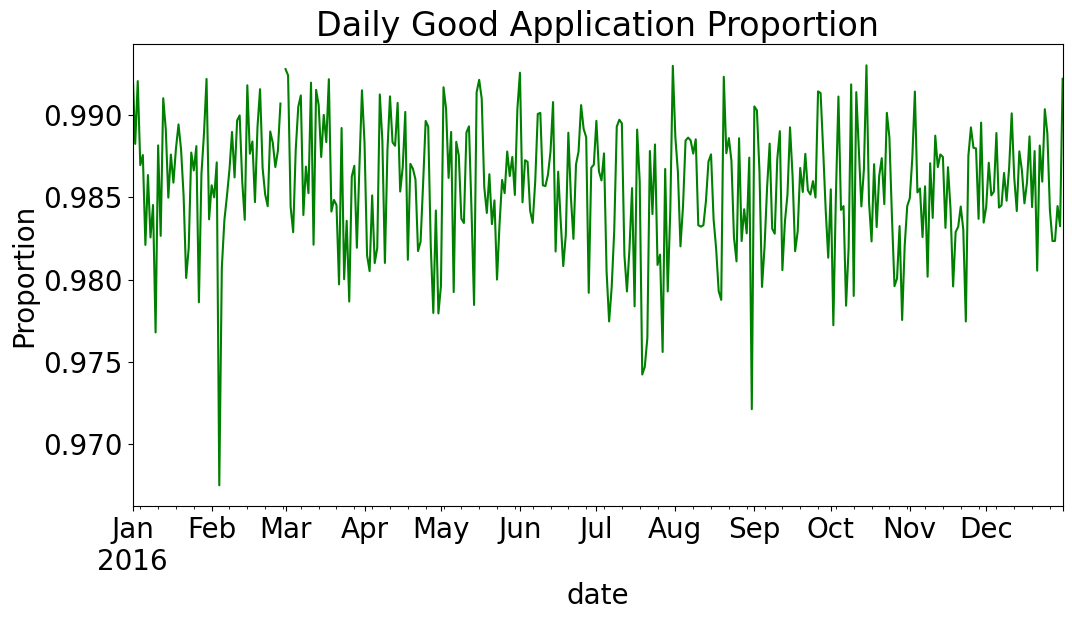

In [34]:
tt_series=goods_series+bads_series
pp_goods_series = goods_series / tt_series
pp_goods_series.plot(color = 'green')
plt.title('Daily Good Application Proportion')
plt.ylabel('Proportion')

<AxesSubplot:title={'center':'Weekly Applications'}, xlabel='date'>

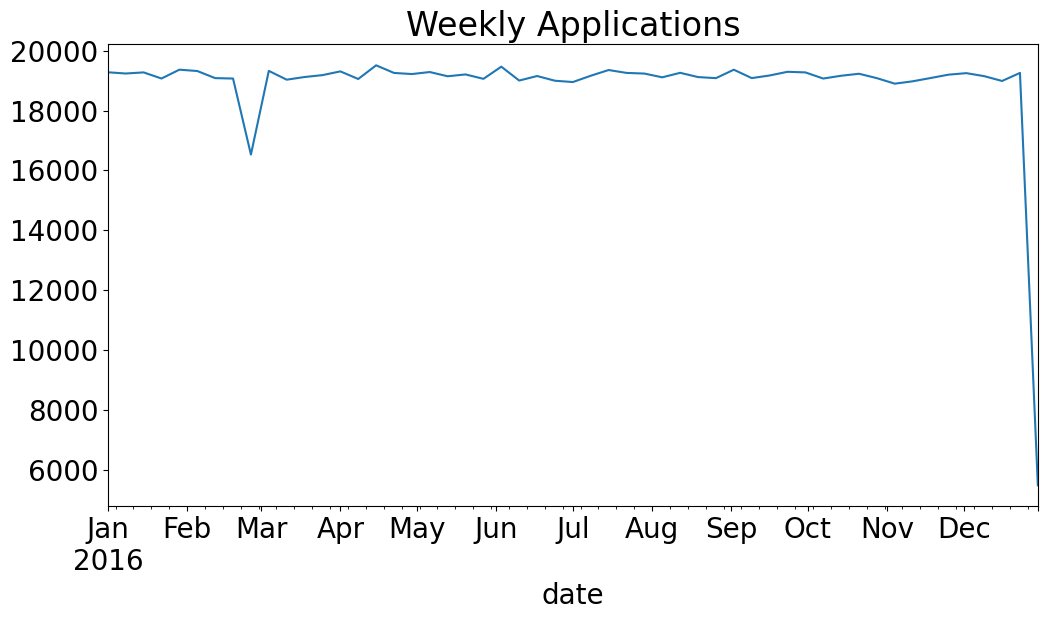

In [35]:
weekly_applications = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 7))\
    .count().apps
weekly_applications.plot(title = 'Weekly Applications')

In [36]:
weekly_applications.head(60)

date
2016-01-01    19276
2016-01-08    19235
2016-01-15    19272
2016-01-22    19068
2016-01-29    19363
2016-02-05    19318
2016-02-12    19081
2016-02-19    19067
2016-02-26    16531
2016-03-04    19323
2016-03-11    19029
2016-03-18    19118
2016-03-25    19181
2016-04-01    19306
2016-04-08    19052
2016-04-15    19508
2016-04-22    19254
2016-04-29    19217
2016-05-06    19284
2016-05-13    19143
2016-05-20    19204
2016-05-27    19057
2016-06-03    19463
2016-06-10    19000
2016-06-17    19151
2016-06-24    18994
2016-07-01    18950
2016-07-08    19160
2016-07-15    19351
2016-07-22    19255
2016-07-29    19233
2016-08-05    19108
2016-08-12    19258
2016-08-19    19116
2016-08-26    19080
2016-09-02    19362
2016-09-09    19082
2016-09-16    19169
2016-09-23    19292
2016-09-30    19272
2016-10-07    19067
2016-10-14    19160
2016-10-21    19227
2016-10-28    19080
2016-11-04    18896
2016-11-11    18975
2016-11-18    19084
2016-11-25    19196
2016-12-02    19247
2016-12-09    1

<AxesSubplot:title={'center':'Weekly Applications'}, xlabel='date'>

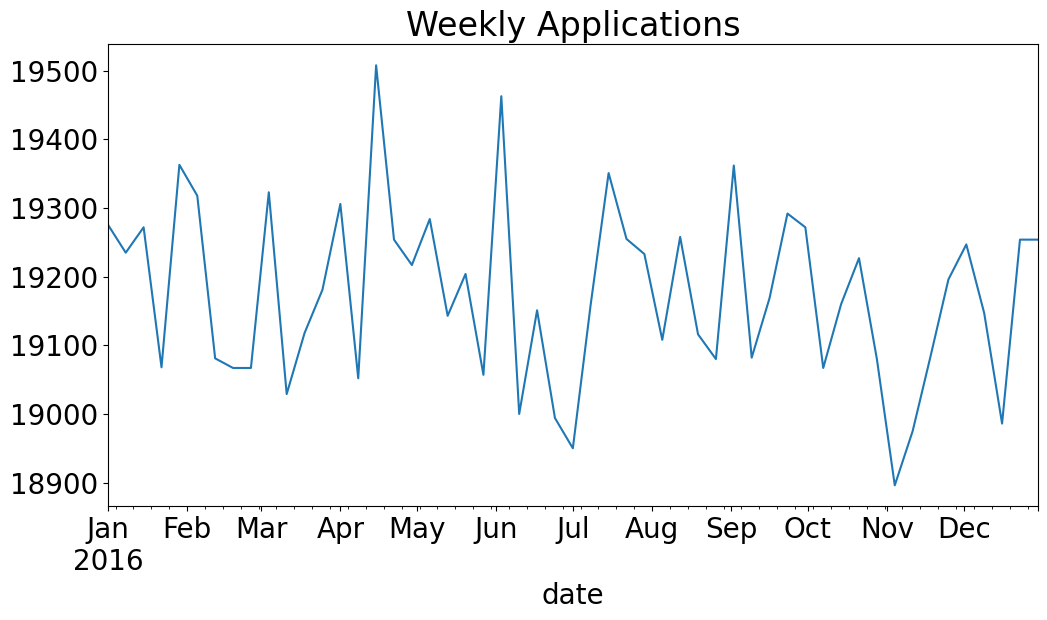

In [37]:
weekly_applications['2016-02-26'] = weekly_applications['2016-02-19']
weekly_applications['2016-12-30'] = weekly_applications['2016-12-23']
weekly_applications.plot(title = 'Weekly Applications')

<AxesSubplot:title={'center':'Weekly Applications'}, xlabel='date'>

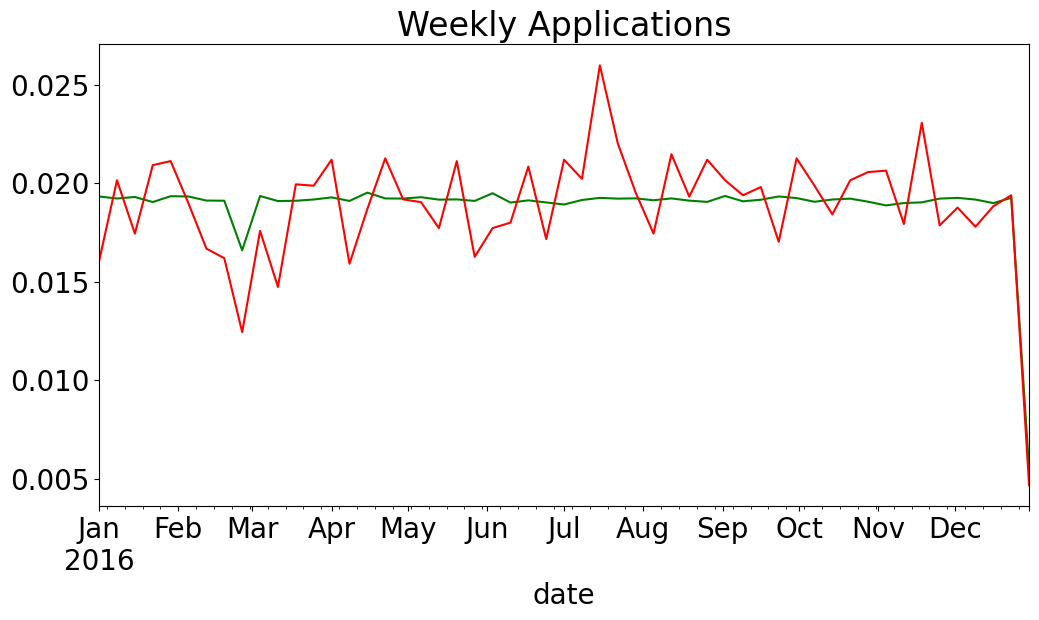

In [38]:
goods_series = goods.assign(apps = np.ones(ngoods)).set_index(goods['date']).resample(dt.timedelta(days = 7)).count().apps
norm_goods_series = goods_series / ngoods
norm_goods_series.plot(title = 'Weekly Applications', color = 'green')
bads_series = bads.assign(apps = np.ones(nbads)).set_index(bads['date']).resample(dt.timedelta(days = 7)).count().apps
norm_bads_series = bads_series / nbads
norm_bads_series.plot(color = 'red')

Text(0, 0.5, 'Proportion')

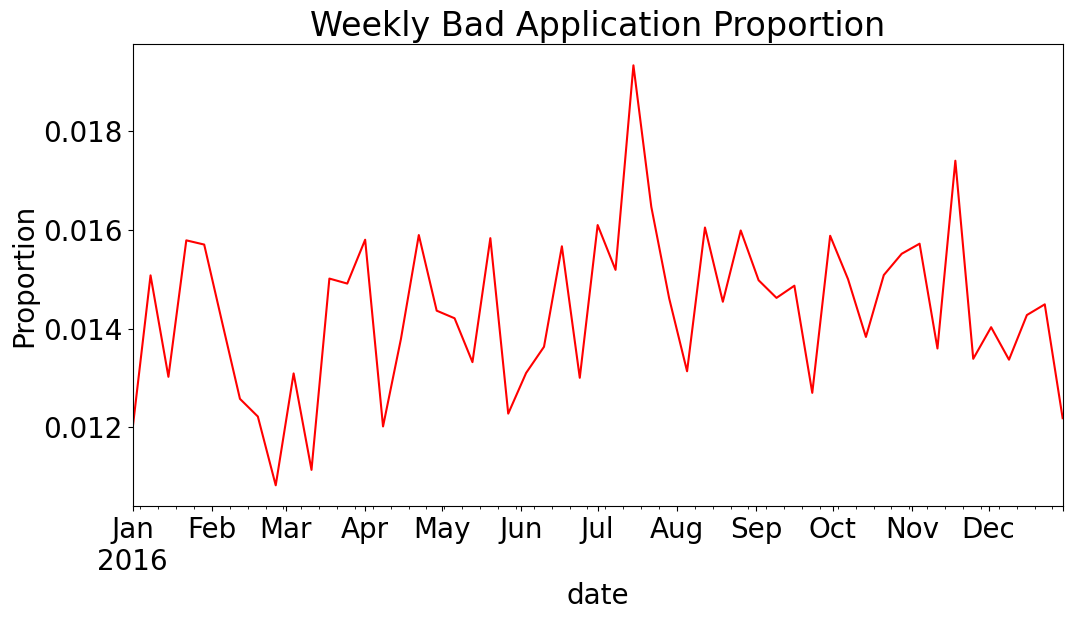

In [39]:
tt_series=goods_series+bads_series
pp_bads_series = bads_series / tt_series
pp_bads_series.plot(color = 'red')
plt.title('Weekly Bad Application Proportion')
plt.ylabel('Proportion')

Text(0, 0.5, 'Proportion')

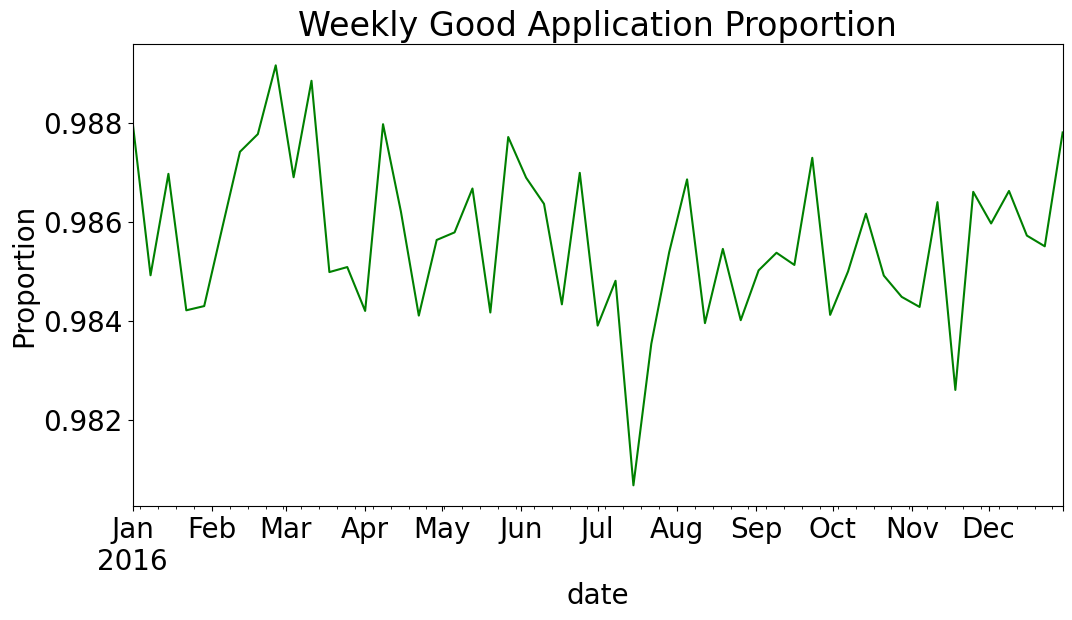

In [40]:
tt_series=goods_series+bads_series
pp_goods_series = goods_series / tt_series
pp_goods_series.plot(color = 'green')
plt.title('Weekly Good Application Proportion')
plt.ylabel('Proportion')

In [41]:
len(data['ssn']) * 100 / numrecords

100.0

In [42]:
len(data['ssn'].unique())

835819

In [43]:
data['ssn'].value_counts()

999999999    16935
938972725      114
810776805       81
829352390       74
473311863       44
             ...  
571979227        1
154696808        1
962389432        1
746697518        1
361232148        1
Name: ssn, Length: 835819, dtype: int64

Text(0.5, 0, 'ssn')

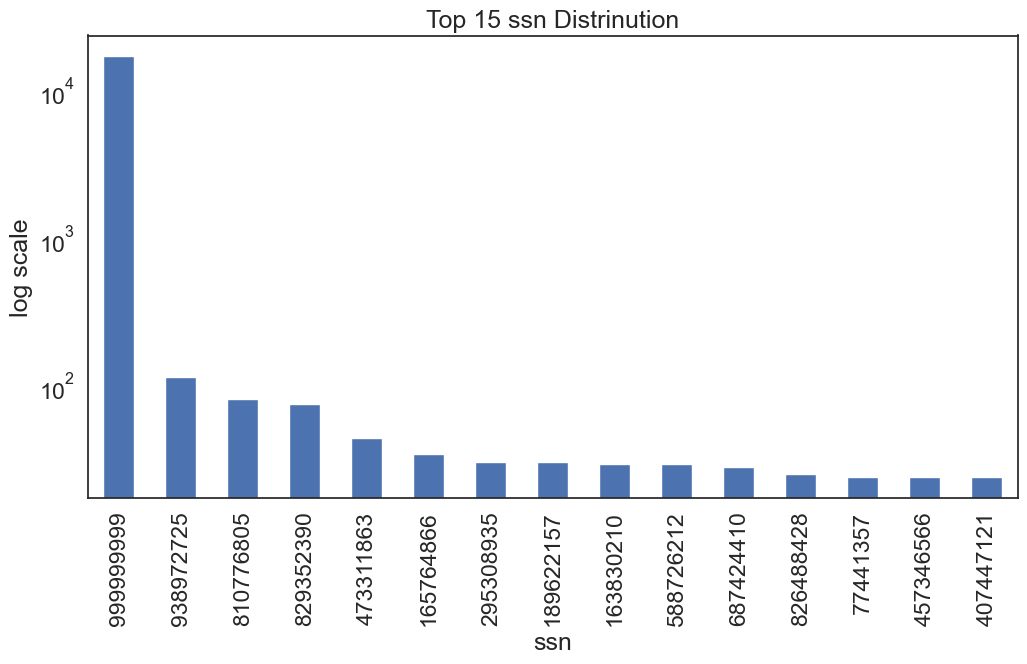

In [44]:
sns.set(font_scale=1.5)
sns.set_style("white")
data['ssn'].value_counts().head(15).plot(kind = 'bar')
plt.yscale('log')
plt.title('Top 15 ssn Distrinution')
plt.ylabel('log scale')
plt.xlabel('ssn')

In [45]:
data[data['ssn'] == 999999999].head(20)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
10,11,2016-01-01,999999999,UZZSMXSEE,USJZUSA,726 UMTXU ST,92129,19400126,3026547212,0
22,23,2016-01-01,999999999,ETXMUSZEM,UJMAMEU,3387 STRUM WY,45982,19580830,5568704443,0
64,65,2016-01-01,999999999,STUMMAMTS,SSJXTUJM,6393 UEJEA LN,41640,19070626,9999999999,0
68,69,2016-01-01,999999999,UUZAJXZMT,SRAAMZXU,2557 URRXS DR,98407,20110831,5490098836,0
74,75,2016-01-01,999999999,AUATMMZX,UUUTAZR,30 ETXRM ST,38402,19760625,2382673773,0
283,284,2016-01-01,999999999,MSJUZSMZJ,UXMTEZUT,356 UZSRE AVE,74187,19070626,153492955,0
380,381,2016-01-01,999999999,XRJSMRRRT,RMRXAMX,9769 UAMZJ DR,52351,19070626,3181686949,0
420,421,2016-01-01,999999999,XRXMTMZEZ,SZRXXJMX,5854 RXRXX PL,34957,19970721,316681200,0
446,447,2016-01-01,999999999,RRZUZUSX,ESZRRRAA,8970 AXME RD,48333,19110729,5350782211,0
468,469,2016-01-01,999999999,XETRJXESR,SSJXTUJM,6995 RMSST CT,48162,19700418,2503172355,0


In [46]:
len(data['firstname']) * 100 / numrecords

100.0

In [47]:
len(data['firstname'].unique())

78136

In [48]:
data['firstname'].value_counts()

EAMSTRMT     12658
TXEMXZZM     10297
UXXJJZTUZ    10235
UJSRSMUEZ     9994
SREZUJMJU     9688
             ...  
TUSSMZJA         1
SSAZJXSRM        1
UATETTATJ        1
UASJMZXZJ        1
RUZUJJRMX        1
Name: firstname, Length: 78136, dtype: int64

Text(0.5, 0, 'firstname')

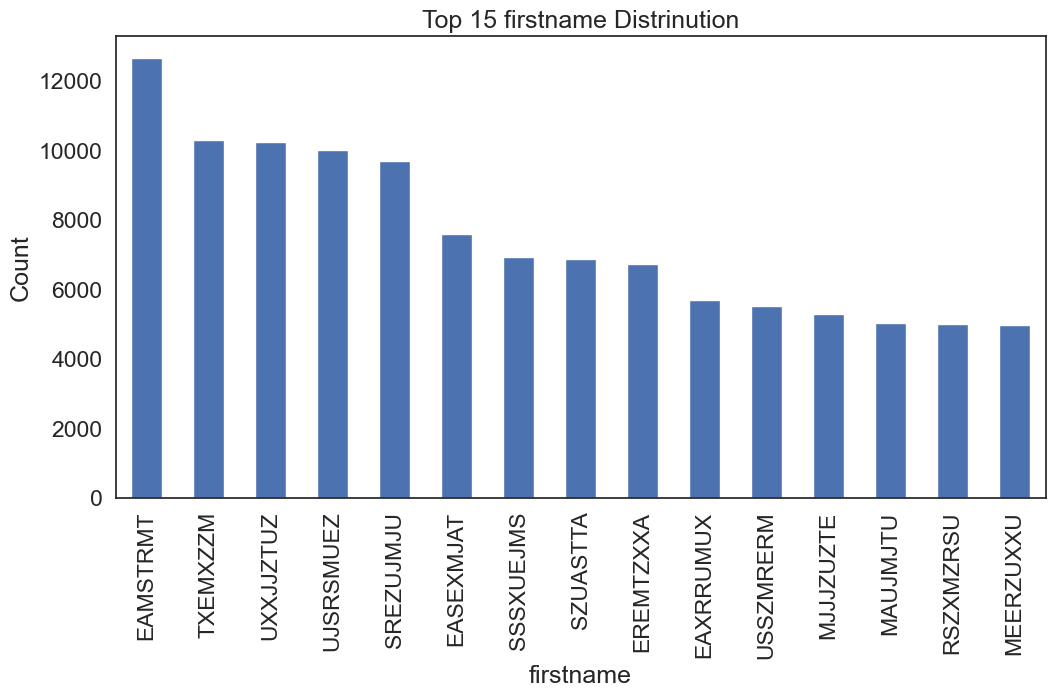

In [49]:
data['firstname'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 firstname Distrinution')
plt.ylabel('Count')
plt.xlabel('firstname')

In [50]:
len(data['lastname']) * 100 / numrecords

100.0

In [51]:
len(data['lastname'].unique())

177001

In [52]:
data['lastname'].value_counts()

ERJSAXA     8580
UMXUUUSE    7156
UMARRMA     6832
MEAXJUX     5492
XMERRR      5451
            ... 
RMJZJRMJ       1
SSUTSMUM       1
EXASZEXS       1
UERZXTTR       1
RMJZURRS       1
Name: lastname, Length: 177001, dtype: int64

Text(0.5, 0, 'lastname')

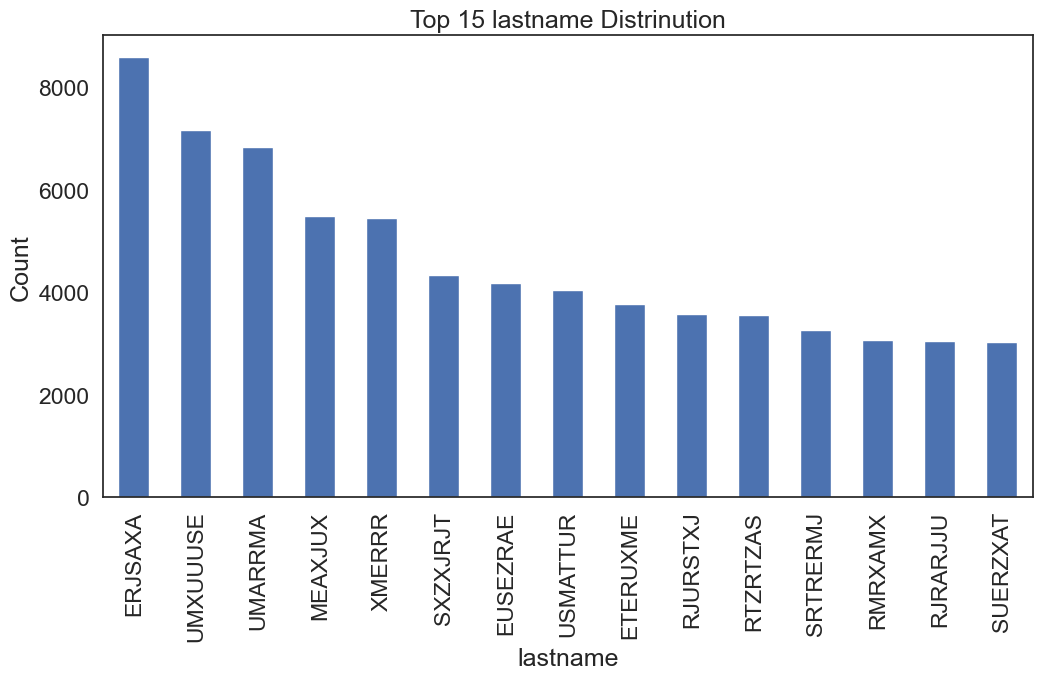

In [53]:
data['lastname'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 lastname Distrinution')
plt.ylabel('Count')
plt.xlabel('lastname')

In [54]:
len(data['address']) * 100 / numrecords

100.0

In [55]:
len(data['address'].unique())

828774

In [56]:
data['address'].value_counts()

123 MAIN ST        1079
1775 XJXE LN         97
7433 RAEZA ST        80
8911 MZSU DR         74
4907 RRAAU DR        73
                   ... 
1179 RATUS BLVD       1
8006 SSRJM ST         1
6327 MAXR ST          1
4937 ESAMR LN         1
3408 UZZAM WY         1
Name: address, Length: 828774, dtype: int64

Text(0.5, 0, 'address')

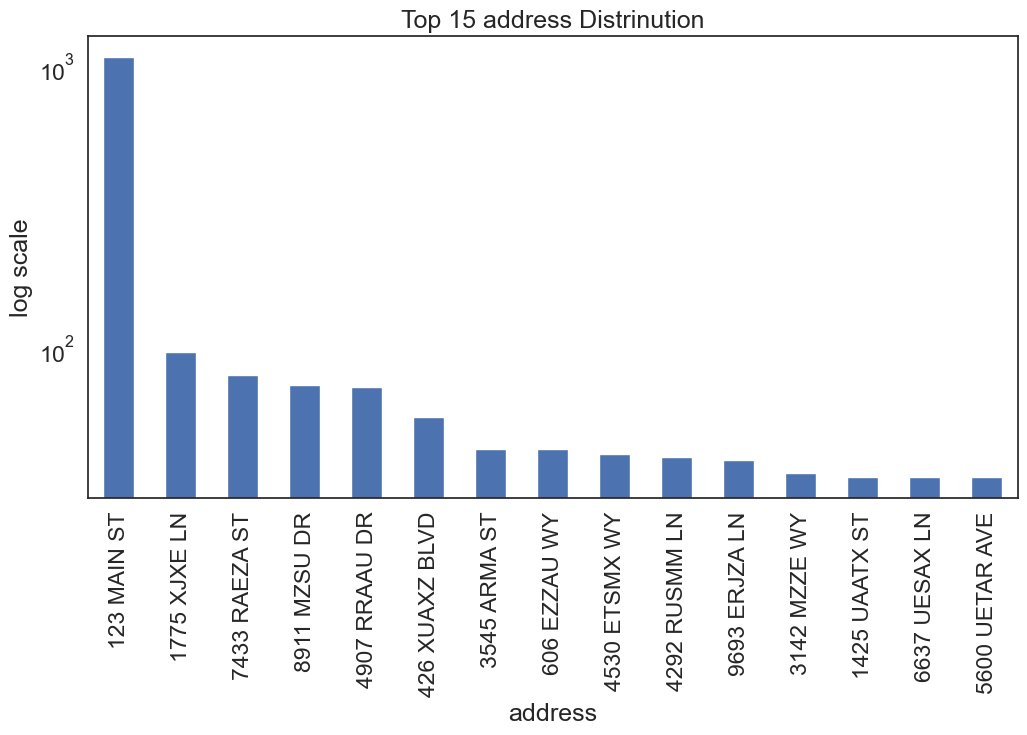

In [57]:
data['address'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 address Distrinution')
plt.ylabel('log scale')
plt.xlabel('address')

In [58]:
data[data['address'] == '123 MAIN ST'].head(20)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
1247,1248,2016-01-01,904524264,UJSRSMUEZ,EAXAXAXA,123 MAIN ST,68138,19241031,8135264540,0
2191,2192,2016-01-01,345413970,XXSMUSEJT,SRRAXESJ,123 MAIN ST,68138,19300526,94097353,0
2529,2530,2016-01-01,821839005,UXZUMTRTR,EARTMRJS,123 MAIN ST,68138,19621101,7715547340,0
3434,3435,2016-01-02,24205988,SXTUZZXAS,UJJAJMM,123 MAIN ST,68138,19640428,8788942828,0
3750,3751,2016-01-02,623763056,SEZESJMSR,UZJEUZMT,123 MAIN ST,68138,19731107,974228226,0
4715,4716,2016-01-02,686787130,SXXSZJMM,ARRZTAA,123 MAIN ST,68138,19810323,1839236819,1
5353,5354,2016-01-02,932938215,UXRJESTM,EETAEAR,123 MAIN ST,68138,19980513,5441682419,0
7299,7300,2016-01-03,417080344,SJETUJAAZ,REMJTREU,123 MAIN ST,92821,19340914,7507186577,0
8512,8513,2016-01-04,477797652,EAMSTRMT,UTXXZZET,123 MAIN ST,68138,19190519,5922864904,0
8750,8751,2016-01-04,6367698,XUERJXSTU,EERMEXAE,123 MAIN ST,42035,19821127,6442565981,0


In [59]:
len(data['zip5']) * 100 / numrecords

100.0

In [60]:
len(data['zip5'].unique())

26370

In [61]:
data['zip5'].value_counts()

68138    823
90042    514
89835    489
35227    478
14931    459
        ... 
1599       1
69474      1
51017      1
25995      1
21226      1
Name: zip5, Length: 26370, dtype: int64

Text(0.5, 0, 'zip5')

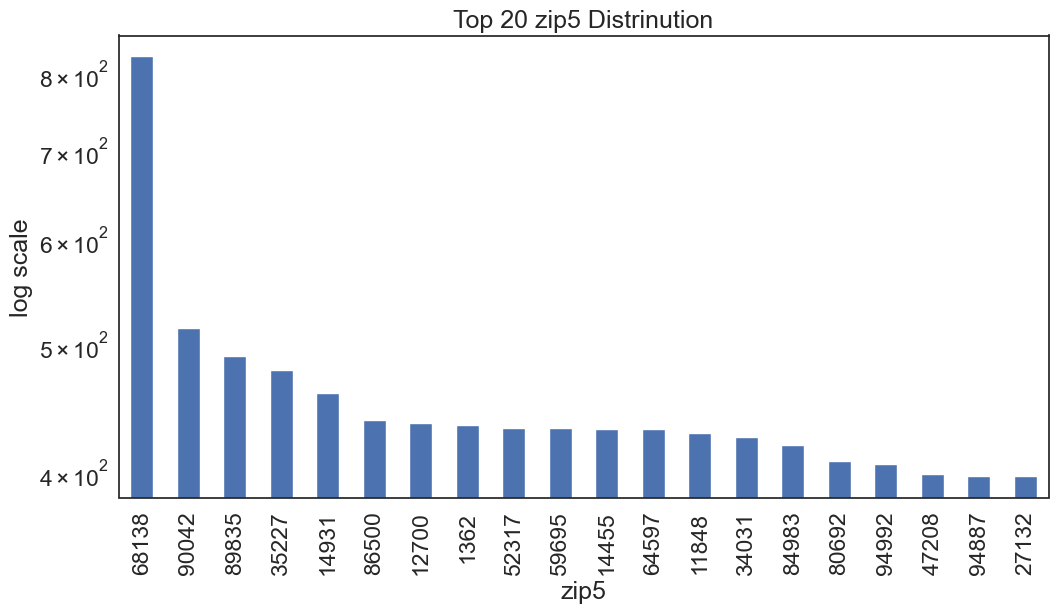

In [62]:
data['zip5'].value_counts().head(20).plot(kind='bar',logy=True)
plt.title('Top 20 zip5 Distrinution')
plt.ylabel('log scale')
plt.xlabel('zip5')

In [63]:
len(data['dob']) * 100 / numrecords

100.0

In [64]:
len(data['dob'].unique())

42673

In [65]:
data['dob'].value_counts()

19070626    126568
19640318      4818
19760625      3723
19880628      1404
19740216       980
             ...  
19280730         5
19860313         5
19190223         5
19441127         5
19960904         5
Name: dob, Length: 42673, dtype: int64

Text(0.5, 0, 'dob')

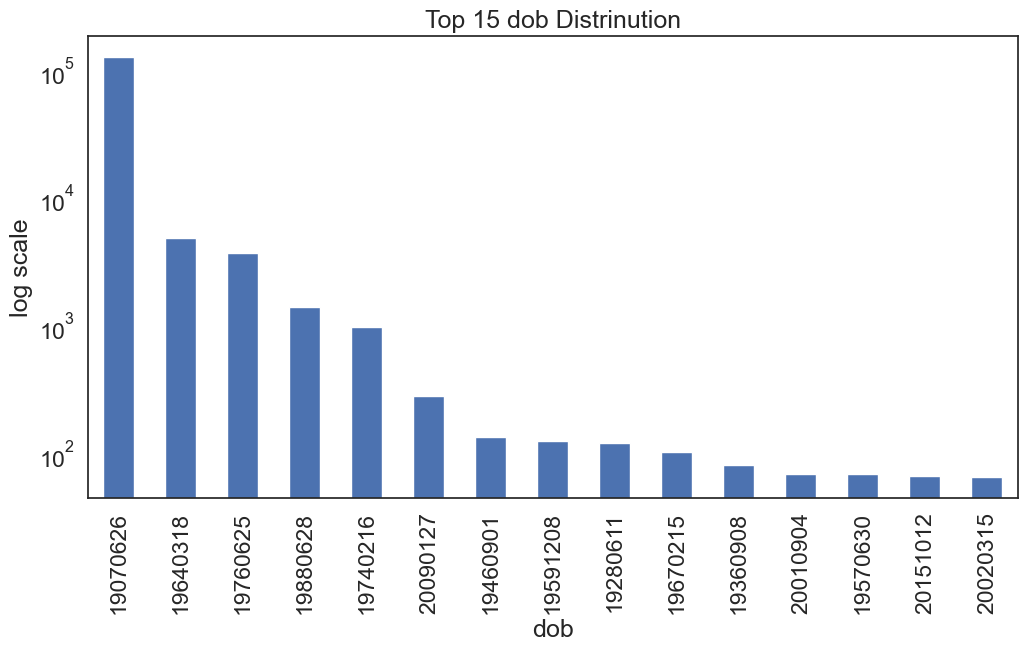

In [66]:
data['dob'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 dob Distrinution')
plt.ylabel('log scale')
plt.xlabel('dob')

<AxesSubplot:xlabel='dob', ylabel='count'>

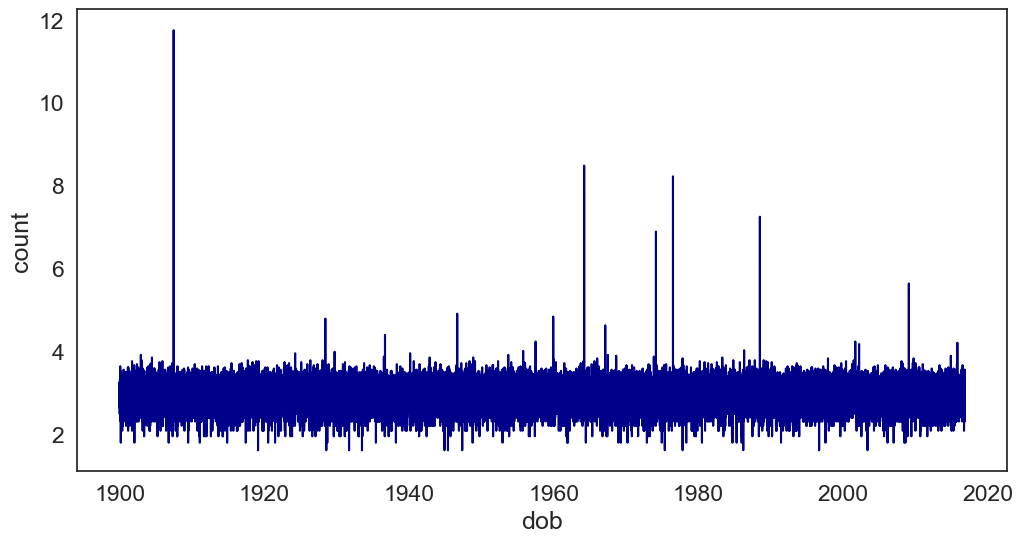

In [67]:
import math
df_dob=pd.DataFrame(data.loc[:,'dob'].value_counts())
df_dob['count']=df_dob['dob']
df_dob['count']=[math.log(i) for i in df_dob['count']]
df_dob['dob']=df_dob.index
df_dob.index=pd.to_datetime(df_dob['dob'],format='%Y%m%d')
df_dob.drop('dob', axis=1,inplace=True)
sns.lineplot(data=df_dob, x=df_dob.index, y=df_dob['count'],color='darkblue')

In [68]:
len(data['homephone']) * 100 / numrecords

100.0

In [69]:
len(data['homephone'].unique())

28244

In [70]:
data['homephone'].value_counts()

9999999999    78512
6384782007      466
6035129044      360
2113738531      331
4024680535      198
              ...  
3450484388        1
5376503138        1
7106175831        1
5010200060        1
6271618925        1
Name: homephone, Length: 28244, dtype: int64

Text(0.5, 0, 'homephone')

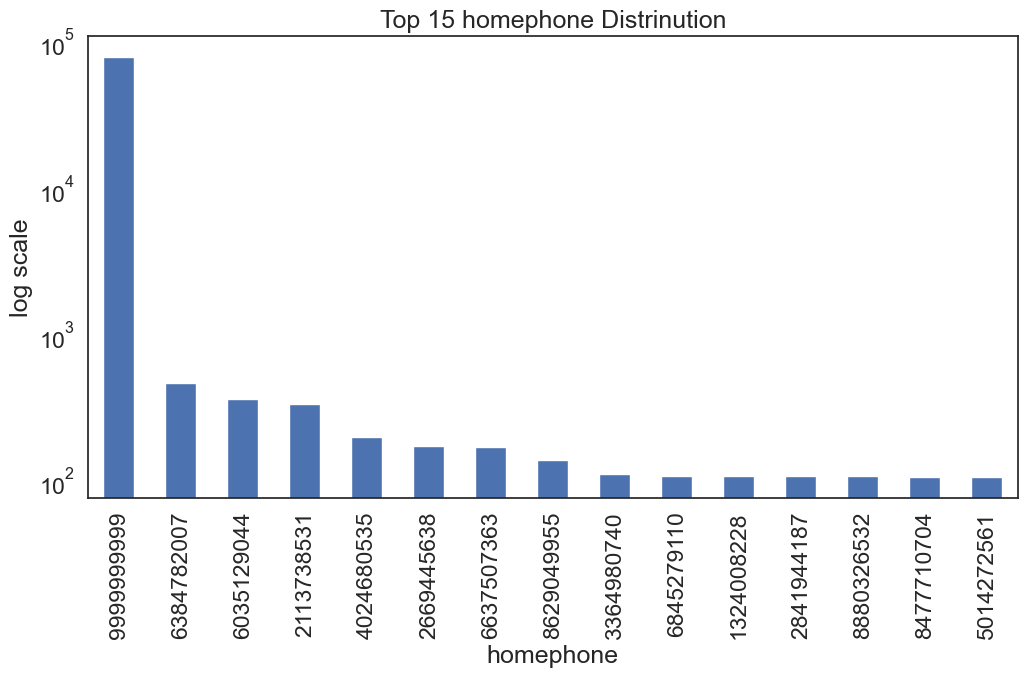

In [71]:
data['homephone'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 homephone Distrinution')
plt.ylabel('log scale')
plt.xlabel('homephone')

In [72]:
data[data['homephone'] == 9999999999].head(10)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
17,18,2016-01-01,346374636,XRSSZZUXT,ETXZXJAJ,5719 UEZJT PL,51486,19500110,9999999999,0
26,27,2016-01-01,735495403,EMSSTSXUA,STZRUXZM,9323 STRMS PL,51395,19881111,9999999999,0
60,61,2016-01-01,780136117,UZTZEETU,ARUZTZM,5317 UTXME ST,37840,19731129,9999999999,0
64,65,2016-01-01,999999999,STUMMAMTS,SSJXTUJM,6393 UEJEA LN,41640,19070626,9999999999,0
145,146,2016-01-01,671506143,TXEMXZZM,SRTERSRA,5795 UMUTM BLVD,45077,19030913,9999999999,0
149,150,2016-01-01,149112205,EZTERXZRA,EERMAXJU,2249 XXAU DR,27375,19841206,9999999999,0
178,179,2016-01-01,507916615,EUEJUURAR,XUSMXRU,8314 XXMX DR,398,19720416,9999999999,0
179,180,2016-01-01,106080337,SRARXRMRM,UTJMRJUX,8413 URUEU WY,15746,19070626,9999999999,0
180,181,2016-01-01,291680381,MUSXJTSSX,EXAAJUT,9762 SXJXM LN,41694,19620504,9999999999,0
200,201,2016-01-01,13382014,EAMSTRMT,RURSXSXX,372 SXTEA DR,42716,19070626,9999999999,0


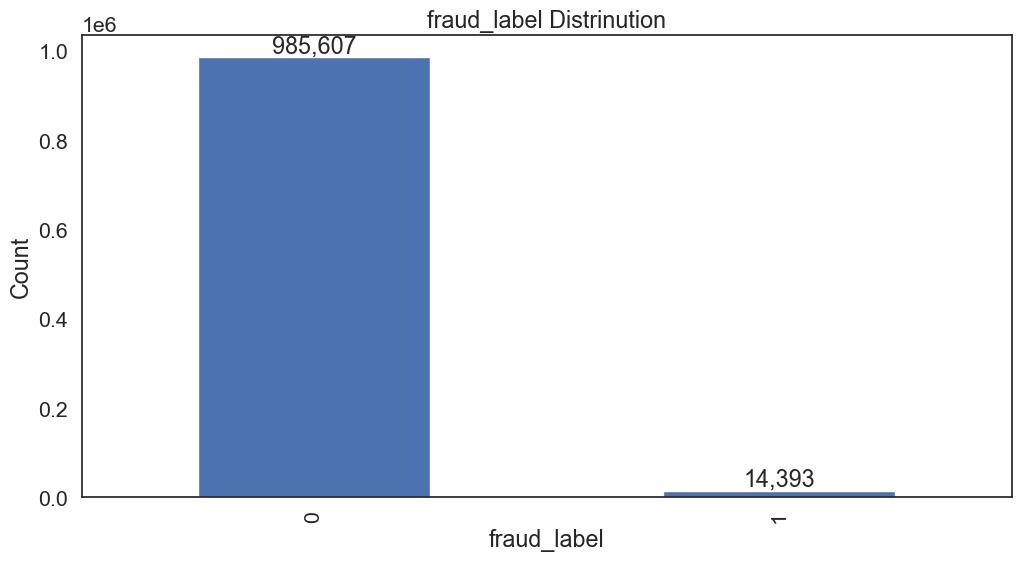

In [73]:
sns.set(font_scale=1.4)
sns.set_style("white")
data['fraud_label'].value_counts().plot(kind = 'bar')
n=[0,1]
s=[985607,14393]
p=['985,607','14,393']
plt.title('fraud_label Distrinution')
plt.ylabel('Count')
plt.xlabel('fraud_label')
for i in range(2):
    plt.annotate(p[i], xy=(n[i],s[i]), ha='center', va='bottom')

In [1]:
from timeit import default_timer as time
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

# Data Explore

data = pd.read_csv('https://raw.githubusercontent.com/Shawn-zou-2020/MyProjects/main/Fraud%20Analysis/Card%20Application%20Fraud%20Analysis/Raw%20Data/applications%20data.csv')

data.shape

len(data['record'])

data.head(10)

data.dtypes

data['appyear'] = (data['date'] / 10000).astype('int')
data['appmonth'] = ((data['date'] - data['appyear'] * 10000) / 100).astype('int')
data['appday'] = data['date'] - data['appyear'] * 10000 - data['appmonth'] * 100
data['date'] = pd.to_datetime(data.appyear*10000+data.appmonth*100+data.appday,format='%Y%m%d')
data = data.drop(columns = ['appyear','appmonth','appday'])

data.dtypes

data.head(5)

data.tail(5)

data.describe()

data.count()

data['fraud_label'].sum()

print(len(data[data['fraud_label'] == 0]))

print(len(data[data['fraud_label'] == 0]) + len(data[data['fraud_label'] != 0]))

goods = data[data['fraud_label'] == 0]
bads = data[data['fraud_label'] == 1]

numrecords = len(data)
print(numrecords)

print(len(goods))

print(len(bads))

len(data['record'].unique())

len(data['record']) * 100 / numrecords

len(data['date']) * 100 / numrecords

len(data['date'].unique())

data.min()

data.max()

count_day = data.groupby('date').count()
count_day.head(10)

daily_count = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 1))\
    .count().apps
daily_count.plot(title = 'Daily Applications')

daily_count = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 1))\
    .count().apps
plt.ylim(2500,3000)
daily_count.plot(title = 'Daily Applications')

daily_count.head(70)

daily_count['2016-02-29'] = daily_count['2016-02-28']
daily_count.head(70)

daily_count.plot(title = 'Daily Applications')

ngoods = len(goods)
nbads = len(bads)
goods_series = goods.assign(apps = np.ones(ngoods)).set_index(goods['date']).resample(dt.timedelta(days = 1)).count().apps
norm_goods_series = goods_series / ngoods
norm_goods_series.plot(title = 'Daily Applicationss', color = 'green')
bads_series = bads.assign(apps = np.ones(nbads)).set_index(bads['date']).resample(dt.timedelta(days = 1)).count().apps
norm_bads_series = bads_series / nbads
norm_bads_series.plot(color = 'red')

tt_series=goods_series+bads_series
pp_bads_series = bads_series / tt_series
pp_bads_series.plot(color = 'red')
plt.title('Daily Bad Application Proportion')
plt.ylabel('Proportion')

tt_series=goods_series+bads_series
pp_goods_series = goods_series / tt_series
pp_goods_series.plot(color = 'green')
plt.title('Daily Good Application Proportion')
plt.ylabel('Proportion')

weekly_applications = data.assign(apps = np.ones(numrecords)).set_index(data['date']).resample(dt.timedelta(days = 7))\
    .count().apps
weekly_applications.plot(title = 'Weekly Applications')

weekly_applications.head(60)

weekly_applications['2016-02-26'] = weekly_applications['2016-02-19']
weekly_applications['2016-12-30'] = weekly_applications['2016-12-23']
weekly_applications.plot(title = 'Weekly Applications')

goods_series = goods.assign(apps = np.ones(ngoods)).set_index(goods['date']).resample(dt.timedelta(days = 7)).count().apps
norm_goods_series = goods_series / ngoods
norm_goods_series.plot(title = 'Weekly Applications', color = 'green')
bads_series = bads.assign(apps = np.ones(nbads)).set_index(bads['date']).resample(dt.timedelta(days = 7)).count().apps
norm_bads_series = bads_series / nbads
norm_bads_series.plot(color = 'red')

tt_series=goods_series+bads_series
pp_bads_series = bads_series / tt_series
pp_bads_series.plot(color = 'red')
plt.title('Weekly Bad Application Proportion')
plt.ylabel('Proportion')

tt_series=goods_series+bads_series
pp_goods_series = goods_series / tt_series
pp_goods_series.plot(color = 'green')
plt.title('Weekly Good Application Proportion')
plt.ylabel('Proportion')

len(data['ssn']) * 100 / numrecords

len(data['ssn'].unique())

data['ssn'].value_counts()

sns.set(font_scale=1.5)
sns.set_style("white")
data['ssn'].value_counts().head(15).plot(kind = 'bar')
plt.yscale('log')
plt.title('Top 15 ssn Distrinution')
plt.ylabel('log scale')
plt.xlabel('ssn')

data[data['ssn'] == 999999999].head(20)

len(data['firstname']) * 100 / numrecords

len(data['firstname'].unique())

data['firstname'].value_counts()

data['firstname'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 firstname Distrinution')
plt.ylabel('Count')
plt.xlabel('firstname')

len(data['lastname']) * 100 / numrecords

len(data['lastname'].unique())

data['lastname'].value_counts()

data['lastname'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 lastname Distrinution')
plt.ylabel('Count')
plt.xlabel('lastname')

len(data['address']) * 100 / numrecords

len(data['address'].unique())

data['address'].value_counts()

data['address'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 address Distrinution')
plt.ylabel('log scale')
plt.xlabel('address')

data[data['address'] == '123 MAIN ST'].head(20)

len(data['zip5']) * 100 / numrecords

len(data['zip5'].unique())

data['zip5'].value_counts()

data['zip5'].value_counts().head(20).plot(kind='bar',logy=True)
plt.title('Top 20 zip5 Distrinution')
plt.ylabel('log scale')
plt.xlabel('zip5')

len(data['dob']) * 100 / numrecords

len(data['dob'].unique())

data['dob'].value_counts()

data['dob'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 dob Distrinution')
plt.ylabel('log scale')
plt.xlabel('dob')

import math
df_dob=pd.DataFrame(data.loc[:,'dob'].value_counts())
df_dob['count']=df_dob['dob']
df_dob['count']=[math.log(i) for i in df_dob['count']]
df_dob['dob']=df_dob.index
df_dob.index=pd.to_datetime(df_dob['dob'],format='%Y%m%d')
df_dob.drop('dob', axis=1,inplace=True)
sns.lineplot(data=df_dob, x=df_dob.index, y=df_dob['count'],color='darkblue')

len(data['homephone']) * 100 / numrecords

len(data['homephone'].unique())

data['homephone'].value_counts()

data['homephone'].value_counts().head(15).plot(kind='bar',logy=True)
plt.title('Top 15 homephone Distrinution')
plt.ylabel('log scale')
plt.xlabel('homephone')

data[data['homephone'] == 9999999999].head(10)

sns.set(font_scale=1.4)
sns.set_style("white")
data['fraud_label'].value_counts().plot(kind = 'bar')
n=[0,1]
s=[985607,14393]
p=['985,607','14,393']
plt.title('fraud_label Distrinution')
plt.ylabel('Count')
plt.xlabel('fraud_label')
for i in range(2):
    plt.annotate(p[i], xy=(n[i],s[i]), ha='center', va='bottom')from timeit import default_timer as time
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

# Data Explore